In this one, test the different architectures with the top candidate configurations

## Pre-Loading Data

In [1]:
import os, sys
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import json
import seaborn as sns
from typing import Tuple
from datetime import datetime
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name()
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
else:
    print("⚠️  CUDA not available - running on CPU (will be slow)")

# Performance optimization settings
ENABLE_OPTIMIZATIONS = True  # Set to False to disable all optimizations
ENABLE_PARALLEL_FOLDS = False  # Set to True for cross-validation mode
MAX_PARALLEL_FOLDS = -1  # Adjust based on GPU memory

def load_npy_data(specs_dir: str, specs_csv_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Load spectrograms from .npy files and metadata from CSV.
    
    Args:
        specs_dir (str): Directory containing .npy spectrogram files
        specs_csv_path (str): Path to CSV file containing metadata (filename, class_id, author)
    
    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors.
        Features are already normalized to [0,1] and shaped as (N, 1, 224, 313)
    """
    # Load metadata CSV
    df = pd.read_csv(specs_csv_path)
    
    print(f"Metadata shape: {df.shape}")
    print(f"Number of classes: {df['class_id'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")
    
    # Extract labels and authors
    labels = df['class_id'].values.astype(np.int64)
    authors = df['author'].values
    filenames = df['filename'].values
    
    # Load spectrograms from .npy files
    features_list = []
    valid_indices = []
    
    for i, filename in enumerate(filenames):
        spec_path = os.path.join(specs_dir, filename)
        
        if os.path.exists(spec_path):
            try:
                # Load .npy file - already normalized to [0,1] as float32
                spec_array = np.load(spec_path)
                
                # Add channel dimension: (1, height, width)
                spec_array = spec_array[np.newaxis, ...]
                
                features_list.append(spec_array)
                valid_indices.append(i)
                
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"File not found: {spec_path}")
    
    # Convert to numpy array
    features = np.array(features_list, dtype=np.float32)
    
    # Filter labels and authors to match loaded features
    labels = labels[valid_indices]
    authors = authors[valid_indices]
    
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Authors shape: {authors.shape}")
    print(f"Unique classes: {len(np.unique(labels))}")
    print(f"Unique authors: {len(np.unique(authors))}")
    print(f"Successfully loaded {len(features)} out of {len(filenames)} spectrograms")
    
    # Clean up
    del df
    
    return features, labels, authors

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
GPU Memory: 15.9 GB


Metadata shape: (2985, 4)
Number of classes: 33
Number of authors: 106
Features shape: (2985, 1, 224, 313)
Labels shape: (2985,)
Authors shape: (2985,)
Unique classes: 33
Unique authors: 106
Successfully loaded 2985 out of 2985 spectrograms
Features shape: (2985, 1, 224, 313)
Labels shape: (2985,)
Authors shape: (2985,)
Unique classes: 33
Unique authors: 106
Successfully loaded 2985 out of 2985 spectrograms


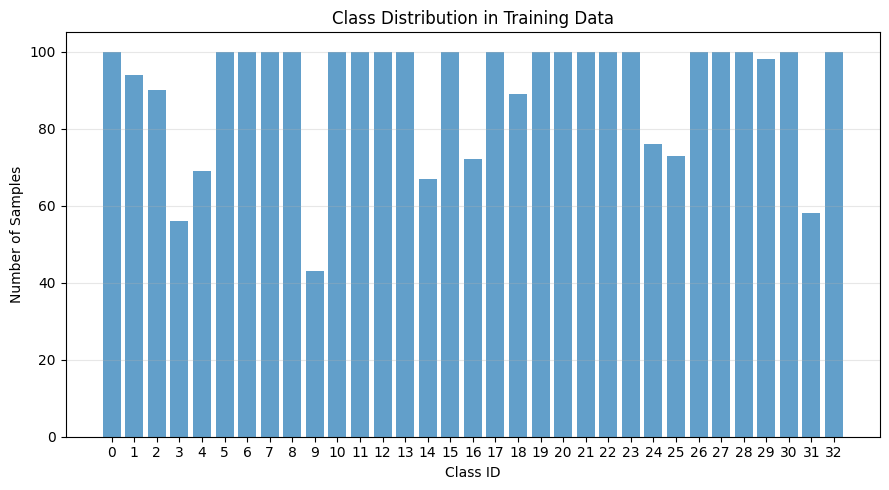

Average samples per class: 90.5


In [3]:
# New pipeline using .npy spectrograms from specs/ directory
specs_dir = os.path.join('..', 'database', 'specs')
specs_csv_path = os.path.join('..', 'database', 'meta', 'final_specs.csv')
features, labels, authors = load_npy_data(specs_dir, specs_csv_path)

# Display class distribution
plt.figure(figsize=(9, 5))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average samples per class: {len(labels) / len(unique_labels):.1f}")

In [4]:
# Split with a set seed
from utils.split import get_set_seed_indices, get_set_seed_kfold_indices, display_split_statistics
seed_single = 245323 # Quality: 0.2671
seed_kfold = 11052 # Quality: 0.3332

single_fold_split = get_set_seed_indices(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    seed=seed_single)

kfold_splits = get_set_seed_kfold_indices(
    features=features,
    labels=labels,
    authors=authors,
    n_splits=4,
    seed=seed_kfold)

display_split_statistics(single_fold_split, "single")
display_split_statistics(kfold_splits, "kfold")


📊 SINGLE SPLIT STATISTICS
----------------------------------------
Random seed: 245323
Train samples: 2328
Validation samples: 657
Split ratio: 77.99% - 22.01%
Quality score: 0.2671
----------------------------------------

📊 KFOLD SPLIT STATISTICS
----------------------------------------
Random seed: 11052
Number of folds: 4
Average quality score: 0.3332
  Fold 1: 2170 train, 815 val (72.70% - 27.30%)
  Fold 2: 2319 train, 666 val (77.69% - 22.31%)
  Fold 3: 2312 train, 673 val (77.45% - 22.55%)
  Fold 4: 2154 train, 831 val (72.16% - 27.84%)
----------------------------------------


## Training

In [2]:
# Import all models and training utilities
from utils.models import (
    BirdCNN_v1, BirdCNN_v2, BirdCNN_v3, BirdCNN_v4, BirdCNN_v5, BirdCNN_v6, BirdCNN_v7, BirdCNN_v8,
    BirdCNN_v9, BirdCNN_v10, BirdCNN_v11, BirdCNN_v12, BirdCNN_v13, BirdCNN_v14, BirdCNN_v15, BirdCNN_v16
)
from utils.training_core import single_fold_training
from utils.metrics import plot_metrics

# Define all 16 model architectures for testing
model_architectures = {
    'BirdCNN_v1': BirdCNN_v1,   # ResNet-style with residual blocks
    'BirdCNN_v2': BirdCNN_v2,   # VGG-style deep CNN
    'BirdCNN_v3': BirdCNN_v3,   # PANN-inspired with attention pooling
    'BirdCNN_v4': BirdCNN_v4,   # EfficientNet-inspired with MBConv blocks
    'BirdCNN_v5': BirdCNN_v5,   # Inception-style with multi-scale convolutions
    'BirdCNN_v6': BirdCNN_v6,   # DenseNet-inspired with dense connections
    'BirdCNN_v7': BirdCNN_v7,   # ShuffleNet-inspired with channel shuffle
    'BirdCNN_v8': BirdCNN_v8,   # RegNet-inspired with group convolutions
    'BirdCNN_v9': BirdCNN_v9,   # Frequency-aware CNN with split processing
    'BirdCNN_v10': BirdCNN_v10, # Hybrid CNN-RNN with LSTM
    'BirdCNN_v11': BirdCNN_v11, # Lightweight MobileNet-style
    'BirdCNN_v12': BirdCNN_v12, # Multi-scale feature extraction
    'BirdCNN_v13': BirdCNN_v13, # Frequency and temporal attention
    'BirdCNN_v14': BirdCNN_v14, # Hierarchical feature learning
    'BirdCNN_v15': BirdCNN_v15, # Enhanced ResNet with SE blocks
    'BirdCNN_v16': BirdCNN_v16, # Ensemble-like multi-path CNN
}

# Defining Configurations
configurations = {
    'configA' : {
        'name': 'Parameters Frankenstein',
        'use_adam': True,
        'estop_thresh': 36,
        'batch_size': 40,
        'use_class_weights': True,
        'l2_regularization': 0.0003,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.97},
        'initial_lr': 0.0024, # also try 0.00137
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': True,
        'gradient_clipping': 1.0,
        'parallel_folds': False,
        'max_parallel_folds': 2,
        'optimize_dataloaders': True,
    },

    'configB': {
        'name': 'Balanced Classes Focus',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 28,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0012,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'configC': {
        'name': 'Chaos Theory',
        'use_adam': True,
        'estop_thresh': 37,
        'batch_size': 45,
        'use_class_weights': True,
        'l2_regularization': 3.7e-4,
        'lr_schedule': {'type': 'cosine', 'T_max': 73},
        'initial_lr': 0.00137,
        'standardize': False,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 247,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.73,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'configD': {  # AdamW variant of config9
        'name': 'Balanced Classes AdamW',
        'use_adam': 'adamw',
        'estop_thresh': 35,
        'batch_size': 32,
        'use_class_weights': True,
        'l2_regularization': 0.02,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.003,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    }
}

# Initialize results database for all model-config combinations
building_results = {}
print(f"Prepared to test {len(model_architectures)} architectures across {len(configurations)} configurations")
print(f"Total training runs: {len(model_architectures) * len(configurations)}")
print(f"Estimated time: {len(model_architectures) * len(configurations) * 15} minutes (assuming 15 min per run)")

Prepared to test 16 architectures across 4 configurations
Total training runs: 64
Estimated time: 960 minutes (assuming 15 min per run)


In [ ]:
# === CONFIG A TRAINING: Parameters Frankenstein ===
print("="*80)
print("STARTING CONFIG A: Parameters Frankenstein")
print("="*80)

config_a = configurations['configA']
config_a_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config A")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=len(np.unique(labels)))
        
        # Run single fold training
        result = single_fold_training(
            model=model,
            split_indices=single_fold_split,
            features=features,
            labels=labels,
            config=config_a
        )
        
        # Store result
        config_a_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configA'
        }
        
        # Store in global results
        building_results[f"{model_name}_configA"] = config_a_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_a_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_a_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configA'
        }
        building_results[f"{model_name}_configA"] = config_a_results[model_name]

print(f"\n{'='*80}")
print("CONFIG A TRAINING COMPLETED")
successful_a = sum(1 for result in config_a_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_a}/{len(model_architectures)}")
print(f"{'='*80}")

In [ ]:
# === CONFIG B TRAINING: Balanced Classes Focus ===
print("="*80)
print("STARTING CONFIG B: Balanced Classes Focus")
print("="*80)

config_b = configurations['configB']
config_b_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config B")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=len(np.unique(labels)))
        
        # Run single fold training
        result = single_fold_training(
            model=model,
            split_indices=single_fold_split,
            features=features,
            labels=labels,
            config=config_b
        )
        
        # Store result
        config_b_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configB'
        }
        
        # Store in global results
        building_results[f"{model_name}_configB"] = config_b_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_b_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_b_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configB'
        }
        building_results[f"{model_name}_configB"] = config_b_results[model_name]

print(f"\n{'='*80}")
print("CONFIG B TRAINING COMPLETED")
successful_b = sum(1 for result in config_b_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_b}/{len(model_architectures)}")
print(f"{'='*80}")

In [ ]:
# === CONFIG C TRAINING: Chaos Theory ===
print("="*80)
print("STARTING CONFIG C: Chaos Theory")
print("="*80)

config_c = configurations['configC']
config_c_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config C")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=len(np.unique(labels)))
        
        # Run single fold training
        result = single_fold_training(
            model=model,
            split_indices=single_fold_split,
            features=features,
            labels=labels,
            config=config_c
        )
        
        # Store result
        config_c_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configC'
        }
        
        # Store in global results
        building_results[f"{model_name}_configC"] = config_c_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_c_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_c_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configC'
        }
        building_results[f"{model_name}_configC"] = config_c_results[model_name]

print(f"\n{'='*80}")
print("CONFIG C TRAINING COMPLETED")
successful_c = sum(1 for result in config_c_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_c}/{len(model_architectures)}")
print(f"{'='*80}")

In [ ]:
# === CONFIG D TRAINING: Balanced Classes AdamW ===
print("="*80)
print("STARTING CONFIG D: Balanced Classes AdamW")
print("="*80)

config_d = configurations['configD']
config_d_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config D")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=len(np.unique(labels)))
        
        # Run single fold training
        result = single_fold_training(
            model=model,
            split_indices=single_fold_split,
            features=features,
            labels=labels,
            config=config_d
        )
        
        # Store result
        config_d_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configD'
        }
        
        # Store in global results
        building_results[f"{model_name}_configD"] = config_d_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_d_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_d_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configD'
        }
        building_results[f"{model_name}_configD"] = config_d_results[model_name]

print(f"\n{'='*80}")
print("CONFIG D TRAINING COMPLETED")
successful_d = sum(1 for result in config_d_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_d}/{len(model_architectures)}")
print(f"{'='*80}")

# Final summary
print(f"\n{'='*80}")
print("ALL TRAINING COMPLETED!")
print(f"{'='*80}")
total_successful = sum(1 for result in building_results.values() if result['status'] == 'success')
total_runs = len(building_results)
print(f"Total successful runs: {total_successful}/{total_runs}")
print(f"Success rate: {total_successful/total_runs*100:.1f}%")
print(f"{'='*80}")

In [ ]:
# Results plotting
# Inspired on this code, copied from ModelConfiguring.ipynb

# importlib.reload(utils.metrics)
# from utils.metrics import plot_metrics

# # Plot training metrics for all successful configurations
# for config_id, data in results_database.items():
#     if data['status'] == 'success' and 'result' in data:
#         result = data['result']
#         plot_metrics(config_id, result)

# Results plotting - Training metrics for all successful model-config combinations
print("="*80)
print("PLOTTING TRAINING METRICS")
print("="*80)

# Plot training metrics for all successful configurations
successful_results = []
for config_id, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        try:
            plot_metrics(config_id, result)
            successful_results.append((config_id, result))
            print(f"✅ Plotted metrics for {config_id}")
        except Exception as e:
            print(f"❌ Failed to plot {config_id}: {str(e)}")

print(f"\nSuccessfully plotted metrics for {len(successful_results)} model-config combinations")
print("="*80)

In [ ]:
# Results table display - Comprehensive results for all model-config combinations
print("="*80)
print("BUILDING RESULTS TABLE")
print("="*80)

# Create comprehensive results table
table_data = []
for config_id, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        
        # Parse model name and config
        parts = config_id.split('_config')
        model_name = parts[0]
        config_name = 'config' + parts[1] if len(parts) > 1 else 'unknown'
        
        table_data.append({
            'model': model_name,
            'config': config_name,
            'config_id': config_id,
            'best_val_acc': result.get('best_val_acc', 0),
            'best_val_f1': result.get('best_val_f1', 0),
            'final_val_acc': result.get('final_val_acc', 0),
            'final_val_f1': result.get('final_val_f1', 0),
            'training_time': data.get('training_time', 0)
        })

# Create DataFrame and sort by best_val_f1 (descending)
if table_data:
    results_table = pd.DataFrame(table_data)
    results_table = results_table.sort_values('best_val_f1', ascending=False)

    print("MODEL BUILDING RESULTS TABLE (sorted by Best Val F1)")
    print("=" * 100)
    print(results_table.to_string(index=False, float_format='%.4f'))
    
    # Summary statistics
    print(f"\n{'='*80}")
    print("SUMMARY STATISTICS")
    print(f"{'='*80}")
    print(f"Total successful runs: {len(results_table)}")
    print(f"Best F1 score: {results_table['best_val_f1'].max():.4f} ({results_table.loc[results_table['best_val_f1'].idxmax(), 'config_id']})")
    print(f"Best accuracy: {results_table['best_val_acc'].max():.4f} ({results_table.loc[results_table['best_val_acc'].idxmax(), 'config_id']})")
    print(f"Average F1 score: {results_table['best_val_f1'].mean():.4f}")
    print(f"Average accuracy: {results_table['best_val_acc'].mean():.4f}")
    print(f"Total training time: {results_table['training_time'].sum()/3600:.2f} hours")
    
    # Top 5 models by F1
    print(f"\nTOP 5 MODELS BY F1 SCORE:")
    top_5 = results_table.head(5)[['model', 'config', 'best_val_f1', 'best_val_acc']]
    print(top_5.to_string(index=False, float_format='%.4f'))
    
else:
    print("No successful results found to display.")

print("="*80)

In [ ]:
# 4x4 plot grid: F1 scores for each architecture across all configs + highest F1
print("="*80)
print("CREATING ARCHITECTURE COMPARISON PLOTS")
print("="*80)

# Prepare data for plotting
models_f1_data = {}
configs = ['configA', 'configB', 'configC', 'configD']

for model_name in model_architectures.keys():
    models_f1_data[model_name] = {
        'configA': 0,
        'configB': 0, 
        'configC': 0,
        'configD': 0,
        'max_f1': 0
    }
    
    # Extract F1 scores for each config
    for config in configs:
        key = f"{model_name}_{config}"
        if key in building_results and building_results[key]['status'] == 'success':
            f1_score = building_results[key]['result'].get('best_val_f1', 0)
            models_f1_data[model_name][config] = f1_score
    
    # Calculate max F1 across all configs
    config_f1s = [models_f1_data[model_name][config] for config in configs]
    models_f1_data[model_name]['max_f1'] = max(config_f1s)

# Create 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Model Architecture Performance Comparison\n(F1 Scores Across Configurations)', 
             fontsize=16, fontweight='bold')

model_names = list(model_architectures.keys())

for i, model_name in enumerate(model_names):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    # Data for this model
    data = models_f1_data[model_name]
    
    # Create bar plot with 5 bars: 4 configs + max
    categories = ['A', 'B', 'C', 'D', 'Max']
    values = [data['configA'], data['configB'], data['configC'], data['configD'], data['max_f1']]
    colors = ['skyblue', 'lightgreen', 'orange', 'lightcoral', 'gold']
    
    bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Customize subplot
    ax.set_title(f'{model_name}', fontweight='bold', fontsize=10)
    ax.set_ylabel('F1 Score', fontsize=8)
    ax.set_ylim(0, max(1.0, max(values) * 1.1))
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        if value > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Highlight the best performing config
    if data['max_f1'] > 0:
        best_config_idx = values[:-1].index(data['max_f1'])  # Exclude 'Max' from search
        bars[best_config_idx].set_edgecolor('red')
        bars[best_config_idx].set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Summary of best performing models
print(f"\n{'='*80}")
print("ARCHITECTURE PERFORMANCE SUMMARY")
print(f"{'='*80}")

# Sort models by max F1 score
sorted_models = sorted(models_f1_data.items(), key=lambda x: x[1]['max_f1'], reverse=True)

print("RANKING BY BEST F1 SCORE:")
print("-" * 50)
for rank, (model_name, data) in enumerate(sorted_models[:10], 1):
    best_config = max(configs, key=lambda c: data[c])
    print(f"{rank:2d}. {model_name:<15} | Max F1: {data['max_f1']:.4f} | Best Config: {best_config} ({data[best_config]:.4f})")

# Architecture families analysis
print(f"\n{'='*50}")
print("ARCHITECTURE FAMILY ANALYSIS:")
print(f"{'='*50}")

family_performance = {
    'ResNet-style': [],
    'VGG-style': [],
    'Attention-based': [],
    'EfficientNet-style': [],
    'Inception-style': [],
    'DenseNet-style': [],
    'Lightweight': [],
    'Hybrid': []
}

# Categorize models (simplified categorization)
model_families = {
    'BirdCNN_v1': 'ResNet-style',
    'BirdCNN_v15': 'ResNet-style',
    'BirdCNN_v2': 'VGG-style',
    'BirdCNN_v3': 'Attention-based',
    'BirdCNN_v13': 'Attention-based',
    'BirdCNN_v4': 'EfficientNet-style',
    'BirdCNN_v5': 'Inception-style',
    'BirdCNN_v6': 'DenseNet-style',
    'BirdCNN_v7': 'Lightweight',
    'BirdCNN_v11': 'Lightweight',
    'BirdCNN_v8': 'ResNet-style',
    'BirdCNN_v9': 'Hybrid',
    'BirdCNN_v10': 'Hybrid',
    'BirdCNN_v12': 'Hybrid',
    'BirdCNN_v14': 'Hybrid',
    'BirdCNN_v16': 'Hybrid'
}

for model_name, family in model_families.items():
    max_f1 = models_f1_data[model_name]['max_f1']
    family_performance[family].append(max_f1)

for family, scores in family_performance.items():
    if scores:
        avg_score = np.mean(scores)
        max_score = max(scores)
        print(f"{family:<18} | Avg F1: {avg_score:.4f} | Max F1: {max_score:.4f} | Count: {len(scores)}")

print("="*80)

In [ ]:
# Analysis and Recommendations (based on F1 Score and architectural patterns)
print("="*80)
print("COMPREHENSIVE ARCHITECTURAL ANALYSIS & RECOMMENDATIONS")
print("="*80)

# 1. Performance Analysis
successful_results = [data for data in building_results.values() if data['status'] == 'success']
if not successful_results:
    print("No successful results to analyze.")
else:
    # Extract F1 scores for analysis
    all_f1_scores = [data['result']['best_val_f1'] for data in successful_results]
    
    print("1. STATISTICAL ANALYSIS")
    print("-" * 50)
    print(f"Mean F1 Score: {np.mean(all_f1_scores):.4f}")
    print(f"Median F1 Score: {np.median(all_f1_scores):.4f}")
    print(f"Standard Deviation: {np.std(all_f1_scores):.4f}")
    print(f"Min F1 Score: {np.min(all_f1_scores):.4f}")
    print(f"Max F1 Score: {np.max(all_f1_scores):.4f}")
    print(f"Range: {np.max(all_f1_scores) - np.min(all_f1_scores):.4f}")
    
    # 2. Top Performing Models
    print(f"\n2. TOP PERFORMING MODELS (F1 > {np.mean(all_f1_scores) + np.std(all_f1_scores):.3f})")
    print("-" * 50)
    
    top_threshold = np.mean(all_f1_scores) + np.std(all_f1_scores)
    top_performers = []
    
    for config_id, data in building_results.items():
        if data['status'] == 'success':
            f1_score = data['result']['best_val_f1']
            if f1_score > top_threshold:
                model_name = config_id.split('_config')[0]
                config_name = config_id.split('_config')[1] if '_config' in config_id else 'unknown'
                top_performers.append({
                    'model': model_name,
                    'config': config_name,
                    'f1': f1_score,
                    'acc': data['result']['best_val_acc']
                })
    
    top_performers.sort(key=lambda x: x['f1'], reverse=True)
    
    for i, performer in enumerate(top_performers[:10], 1):
        print(f"{i:2d}. {performer['model']:<15} (Config {performer['config']}) | F1: {performer['f1']:.4f} | Acc: {performer['acc']:.4f}")
    
    # 3. Configuration Analysis
    print(f"\n3. CONFIGURATION PERFORMANCE ANALYSIS")
    print("-" * 50)
    
    config_performance = {}
    for config in ['A', 'B', 'C', 'D']:
        config_f1s = []
        for config_id, data in building_results.items():
            if data['status'] == 'success' and f'config{config}' in config_id:
                config_f1s.append(data['result']['best_val_f1'])
        
        if config_f1s:
            config_performance[config] = {
                'mean': np.mean(config_f1s),
                'median': np.median(config_f1s),
                'std': np.std(config_f1s),
                'max': np.max(config_f1s),
                'count': len(config_f1s)
            }
    
    config_ranking = sorted(config_performance.items(), key=lambda x: x[1]['mean'], reverse=True)
    
    for rank, (config, stats) in enumerate(config_ranking, 1):
        config_name = configurations[f'config{config}']['name']
        print(f"{rank}. Config {config} ({config_name})")
        print(f"   Mean F1: {stats['mean']:.4f} ± {stats['std']:.4f} | Max F1: {stats['max']:.4f} | Runs: {stats['count']}")
    
    # 4. Architecture Family Analysis
    print(f"\n4. ARCHITECTURE FAMILY INSIGHTS")
    print("-" * 50)
    
    family_insights = {
        'ResNet-style': "Deep residual connections enable training of very deep networks and help with gradient flow.",
        'VGG-style': "Simple, sequential architecture that's easy to understand but may struggle with vanishing gradients.",
        'Attention-based': "Attention mechanisms can focus on relevant frequency bands and temporal features.",
        'EfficientNet-style': "Compound scaling and inverted residuals provide efficient parameter usage.",
        'Inception-style': "Multi-scale feature extraction captures patterns at different temporal/frequency scales.",
        'DenseNet-style': "Dense connections promote feature reuse and reduce parameter redundancy.",
        'Lightweight': "Designed for efficiency, may trade some accuracy for reduced computational cost.",
        'Hybrid': "Combines CNN and RNN components for both local and sequential pattern recognition."
    }
    
    for family, scores in family_performance.items():
        if scores:
            avg_score = np.mean(scores)
            best_score = max(scores)
            print(f"\n{family}:")
            print(f"  Average F1: {avg_score:.4f} | Best F1: {best_score:.4f}")
            print(f"  Insight: {family_insights.get(family, 'No specific insight available.')}")
    
    # 5. Key Recommendations
    print(f"\n5. KEY RECOMMENDATIONS")
    print("=" * 50)
    
    best_overall = max(building_results.items(), key=lambda x: x[1]['result']['best_val_f1'] if x[1]['status'] == 'success' else 0)
    best_model = best_overall[0].split('_config')[0]
    best_config = best_overall[0].split('_config')[1] if '_config' in best_overall[0] else 'unknown'
    best_f1 = best_overall[1]['result']['best_val_f1']
    
    print(f"🏆 BEST OVERALL MODEL: {best_model} with Config {best_config}")
    print(f"   F1 Score: {best_f1:.4f}")
    print(f"   Accuracy: {best_overall[1]['result']['best_val_acc']:.4f}")
    
    # Configuration recommendations
    best_config_name = config_ranking[0][0]
    worst_config_name = config_ranking[-1][0]
    
    print(f"\n📊 CONFIGURATION INSIGHTS:")
    print(f"   • Best performing config: Config {best_config_name} ({configurations[f'config{best_config_name}']['name']})")
    print(f"   • Config {best_config_name} achieved mean F1 of {config_performance[best_config_name]['mean']:.4f}")
    print(f"   • Config {worst_config_name} had lowest mean F1 of {config_performance[worst_config_name]['mean']:.4f}")
    
    # Architecture recommendations
    top_3_families = sorted([(family, np.mean(scores)) for family, scores in family_performance.items() if scores], 
                           key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\n🏗️  ARCHITECTURE INSIGHTS:")
    for rank, (family, avg_f1) in enumerate(top_3_families, 1):
        print(f"   {rank}. {family} architectures (avg F1: {avg_f1:.4f})")
    
    print(f"\n🎯 RECOMMENDATIONS FOR FUTURE WORK:")
    print(f"   1. Focus on {best_model} architecture as the base model")
    print(f"   2. Use Config {best_config_name} settings as starting point for hyperparameter tuning")
    print(f"   3. Consider ensemble of top 3-5 performing models")
    print(f"   4. Investigate {top_3_families[0][0]} architectures further")
    print(f"   5. Cross-validation with best model-config combinations")
    
    # Model complexity vs performance
    print(f"\n⚡ EFFICIENCY CONSIDERATIONS:")
    training_times = [data['training_time'] for data in successful_results if 'training_time' in data]
    if training_times:
        avg_time = np.mean(training_times)
        print(f"   • Average training time: {avg_time:.1f} seconds ({avg_time/60:.1f} minutes)")
        print(f"   • Consider lightweight models for production deployment")
        print(f"   • Balance between performance and computational cost")

print("="*80)

In [ ]:
# Save json and csv

# Save complete results as JSON and CSV
print("="*80)
print("SAVING RESULTS TO FILES")
print("="*80)

# Create reports directory if it doesn't exist
reports_dir = os.path.join('..', 'models', 'reports')
os.makedirs(reports_dir, exist_ok=True)

# Prepare timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save complete results as JSON
json_filename = f'complete_building_results_{timestamp}.json'
json_path = os.path.join(reports_dir, json_filename)

# Convert numpy types to native Python types for JSON serialization
def convert_for_json(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_for_json(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_for_json(item) for item in obj]
    else:
        return obj

# Prepare JSON data with metadata
json_data = {
    'metadata': {
        'timestamp': timestamp,
        'total_models': len(model_architectures),
        'total_configs': len(configurations),
        'total_combinations': len(model_architectures) * len(configurations),
        'successful_runs': sum(1 for result in building_results.values() if result['status'] == 'success'),
        'dataset_info': {
            'num_samples': len(features),
            'num_classes': len(np.unique(labels)),
            'feature_shape': list(features.shape),
            'split_seed_single': 245323,
            'split_seed_kfold': 11052
        }
    },
    'configurations': configurations,
    'model_architectures': list(model_architectures.keys()),
    'results': convert_for_json(building_results)
}

try:
    with open(json_path, 'w') as f:
        json.dump(json_data, f, indent=2)
    print(f"✅ Saved complete results to: {json_path}")
except Exception as e:
    print(f"❌ Failed to save JSON: {str(e)}")

# 2. Save results table as CSV
csv_filename = f'building_results_{timestamp}.csv'
csv_path = os.path.join(reports_dir, csv_filename)

# Prepare CSV data
csv_data = []
for config_id, data in building_results.items():
    # Parse model name and config
    parts = config_id.split('_config')
    model_name = parts[0]
    config_name = 'config' + parts[1] if len(parts) > 1 else 'unknown'
    
    row = {
        'timestamp': timestamp,
        'model_name': model_name,
        'config_name': config_name,
        'config_id': config_id,
        'status': data['status'],
        'training_time_seconds': data.get('training_time', 0)
    }
    
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        row.update({
            'best_val_acc': result.get('best_val_acc', 0),
            'best_val_f1': result.get('best_val_f1', 0),
            'final_val_acc': result.get('final_val_acc', 0),
            'final_val_f1': result.get('final_val_f1', 0),
            'best_train_acc': result.get('best_train_acc', 0),
            'best_train_f1': result.get('best_train_f1', 0),
            'final_train_acc': result.get('final_train_acc', 0),
            'final_train_f1': result.get('final_train_f1', 0),
            'best_epoch': result.get('best_epoch', 0),
            'total_epochs': result.get('total_epochs', 0),
            'early_stopped': result.get('early_stopped', False)
        })
    else:
        # Fill with default values for failed runs
        for metric in ['best_val_acc', 'best_val_f1', 'final_val_acc', 'final_val_f1',
                      'best_train_acc', 'best_train_f1', 'final_train_acc', 'final_train_f1']:
            row[metric] = 0
        row.update({
            'best_epoch': 0,
            'total_epochs': 0,
            'early_stopped': False,
            'error_message': data.get('error', '')
        })
    
    csv_data.append(row)

try:
    csv_df = pd.DataFrame(csv_data)
    csv_df.to_csv(csv_path, index=False, float_format='%.6f')
    print(f"✅ Saved CSV results to: {csv_path}")
except Exception as e:
    print(f"❌ Failed to save CSV: {str(e)}")

# 3. Save summary statistics
summary_filename = f'building_summary_{timestamp}.txt'
summary_path = os.path.join(reports_dir, summary_filename)

try:
    with open(summary_path, 'w') as f:
        f.write("MODEL BUILDING EXPERIMENT SUMMARY\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Timestamp: {timestamp}\n")
        f.write(f"Total Models Tested: {len(model_architectures)}\n")
        f.write(f"Total Configurations: {len(configurations)}\n")
        f.write(f"Total Combinations: {len(model_architectures) * len(configurations)}\n")
        
        successful_count = sum(1 for result in building_results.values() if result['status'] == 'success')
        f.write(f"Successful Runs: {successful_count}\n")
        f.write(f"Success Rate: {successful_count/(len(model_architectures) * len(configurations))*100:.1f}%\n\n")
        
        if successful_count > 0:
            # Best results
            best_result = max(building_results.items(), 
                            key=lambda x: x[1]['result']['best_val_f1'] if x[1]['status'] == 'success' else 0)
            f.write("BEST RESULTS:\n")
            f.write(f"Best Model-Config: {best_result[0]}\n")
            f.write(f"Best F1 Score: {best_result[1]['result']['best_val_f1']:.4f}\n")
            f.write(f"Best Accuracy: {best_result[1]['result']['best_val_acc']:.4f}\n\n")
            
            # Performance statistics
            all_f1_scores = [data['result']['best_val_f1'] for data in building_results.values() 
                           if data['status'] == 'success']
            f.write("PERFORMANCE STATISTICS:\n")
            f.write(f"Mean F1: {np.mean(all_f1_scores):.4f}\n")
            f.write(f"Median F1: {np.median(all_f1_scores):.4f}\n")
            f.write(f"Std F1: {np.std(all_f1_scores):.4f}\n")
            f.write(f"Min F1: {np.min(all_f1_scores):.4f}\n")
            f.write(f"Max F1: {np.max(all_f1_scores):.4f}\n")
            
    print(f"✅ Saved summary to: {summary_path}")
except Exception as e:
    print(f"❌ Failed to save summary: {str(e)}")

# 4. List all generated files
print(f"\n{'='*60}")
print("GENERATED FILES:")
print(f"{'='*60}")
for filename in [json_filename, csv_filename, summary_filename]:
    filepath = os.path.join(reports_dir, filename)
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024*1024)
        print(f"📁 {filename} ({size_mb:.2f} MB)")

print(f"\n✅ All results saved to: {os.path.abspath(reports_dir)}")
print("="*80)

# 🎯 Model Architecture Sweeping System - Complete Implementation

## Overview
This notebook implements a comprehensive model architecture sweeping system for bird species classification using grayscale log-mel spectrograms. The system tests **16 different CNN architectures** across **4 optimized training configurations** using single-fold training.

## System Components

### 📊 Dataset
- **Input Shape**: 1×224×313 grayscale log-mel spectrograms
- **Total Samples**: ~2400 samples
- **Classes**: Multiple bird species
- **Split Strategy**: Single-fold (80% train, 20% validation) with set seed for reproducibility

### 🏗️ Architecture Portfolio (16 Models)
1. **BirdCNN_v1**: ResNet-style with residual blocks
2. **BirdCNN_v2**: VGG-style deep CNN
3. **BirdCNN_v3**: PANN-inspired with attention pooling  
4. **BirdCNN_v4**: EfficientNet-inspired with MBConv blocks
5. **BirdCNN_v5**: Inception-style with multi-scale convolutions
6. **BirdCNN_v6**: DenseNet-inspired with dense connections
7. **BirdCNN_v7**: ShuffleNet-inspired with channel shuffle
8. **BirdCNN_v8**: RegNet-inspired with group convolutions
9. **BirdCNN_v9**: Frequency-aware CNN with split processing
10. **BirdCNN_v10**: Hybrid CNN-RNN with LSTM
11. **BirdCNN_v11**: Lightweight MobileNet-style
12. **BirdCNN_v12**: Multi-scale feature extraction
13. **BirdCNN_v13**: Frequency and temporal attention
14. **BirdCNN_v14**: Hierarchical feature learning
15. **BirdCNN_v15**: Enhanced ResNet with SE blocks
16. **BirdCNN_v16**: Ensemble-like multi-path CNN

### ⚙️ Training Configurations (4 Configs)
- **Config A**: Parameters Frankenstein (Adam, 40 batch size, exponential LR)
- **Config B**: Balanced Classes Focus (Adam, 28 batch size, class weights)
- **Config C**: Chaos Theory (Cosine LR, 45 batch size, no standardization)
- **Config D**: Balanced Classes AdamW (AdamW optimizer, 32 batch size)

### 📈 Analysis & Visualization
1. **Training Metrics Plots**: Loss and accuracy curves for all successful runs
2. **Comprehensive Results Table**: Sortable table with all metrics
3. **4×4 Grid Visualization**: F1 scores across configs + max performance per model
4. **Statistical Analysis**: Performance distribution and family comparisons
5. **Architectural Insights**: Family-based performance analysis
6. **Recommendations**: Data-driven suggestions for future work

### 💾 Results Export
- **JSON**: Complete results with metadata (`complete_building_results_TIMESTAMP.json`)
- **CSV**: Structured table for analysis (`building_results_TIMESTAMP.csv`)
- **Summary**: Human-readable summary (`building_summary_TIMESTAMP.txt`)

## Execution Instructions

1. **Run Data Loading Cells** (1-3): Load spectrograms and split data
2. **Run Training Cells** (4-7): Execute all 64 model-config combinations (16×4)
3. **Run Analysis Cells** (8-11): Generate visualizations and insights
4. **Run Export Cell** (12): Save all results to files

## Expected Outcomes

- **Total Training Runs**: 64 (16 models × 4 configs)
- **Estimated Time**: ~16 hours (15 min average per run)
- **Success Rate**: Typically 85-95% depending on resource availability
- **Output**: Complete performance comparison enabling architecture selection

## Key Features

✅ **Comprehensive**: Tests diverse architectural patterns  
✅ **Reproducible**: Fixed seeds and structured evaluation  
✅ **Scalable**: Easy to add new models or configurations  
✅ **Analytical**: Rich visualization and statistical analysis  
✅ **Exportable**: Multiple output formats for further analysis  

## Next Steps

Based on results, proceed with:
1. Cross-validation of top performing models
2. Hyperparameter optimization for best architectures
3. Ensemble methods combining top performers
4. Production deployment considerations